   # Find cloud position from l, b, VLSR

In [2]:
import numpy as np
import pylab 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc

rc('mathtext',default='regular')

%matplotlib notebook
#%matplotlib inline

## Function to read cloud data

In [3]:
def get_xy_data(cols,filename=None):
    """
    Utility function to retrieve x,y vectors form an ASCII data file.
    It return the first column as x, the second as y.
    Usage:
        x,y = get_xy_data("mydata.txt")
    """
    data = np.loadtxt(filename, usecols=cols)
    return data

## NMG attempt to derive position (ignore)
Define $\theta$ as the angle from the Sun-GC line, right-hand cylindrical, such that $l=\theta$ if the object is at infinity

Define $\phi$ as the angle from the Z-axis

In [4]:
# NM-G attempt at deriving positions
def VLSR(l,b,theta,VR,VZ):
    R0 = 8.5
    V0 = -220.
    l_rad = np.radians(l)
    b_rad = np.radians(b)
    theta_rad = np.radians(theta)
    VLSR = np.cos(b_rad) * (R0 * np.sin(l_rad) * V0/R0  + VR*np.cos(l_rad - theta_rad)) + VZ * np.sin(b_rad)
    return VLSR

In [5]:
# NM-G attempt at deriving positions
def pos(l,b):
    R0 = 8.5
    Vw = 200.
# Define an array of distance to work along
    r = np.arange(0.1,16.1,0.1)
    rxy = r * np.cos(np.radians(b))
    rzx = r * np.cos(np.radians(l))
    rprime = np.sqrt(R0**2 + rzx**2 - (2*rzx * R0 * np.cos(np.radians(b))))
    term = (rzx**2 + rprime**2 - R0**2)/(2.*rzx*rprime)
    gamma = np.degrees(np.arccos(term))
    phi = 90. - b - gamma
    rprime = np.sqrt(R0**2 + rxy**2 - (2*rxy * R0 * np.cos(np.radians(l))))
    term = (rxy**2 + rprime**2 - R0**2)/(2.*rxy*rprime)
    gamma = np.degrees(np.arccos(term))
    theta =  l + gamma  
    
# Now get the VR, VZ 
    VR = Vw * np.sin(np.radians(90.0 - phi))
    VZ = Vw * np.cos(np.radians(90.0 - phi))

# And finally calculate the VLSR 
    v = VLSR(l,b,theta,VR,VZ)
    
    return phi, theta, v

## Read the GBT cloud positions

In [6]:
# Read in the GBT data
dat = get_xy_data((3,4,5),"clouds_GBT_coord.txt")
lon = dat[:,0]
lat = dat[:,1]
vel = dat[:,2]
for i in range(len(lon)):
    if lon[i]>180.0:
        lon[i]=lon[i]-360.0

## Read the ATCA cloud positions

In [7]:
# Read in the ATCA cloud data
dat = get_xy_data((1,2,3),"GC_cloudprop.dat")
atca_lon = dat[:,0]
atca_lat = dat[:,1]
atca_vel = dat[:,2]
for i in range(len(atca_lon)):
    if atca_lon[i]>180.0:
        atca_lon[i]=lon[i]-360.0

## Calculate the cloud positions from the velocities

In [8]:
# Modified code frm Jay to calculate the position of a cloud

def derived_props(lon,lat,vel,Vw):
    nclouds = len(lon)
    dist_index = np.zeros(nclouds)
    derived_cloud_R = np.zeros(nclouds)
    derived_cloud_dGC = np.zeros(nclouds)
    derived_cloud_z = np.zeros(nclouds)
    derived_cloud_x = np.zeros(nclouds)
    derived_cloud_y = np.zeros(nclouds)
    derived_cloud_theta = np.zeros(nclouds)
    derived_VLSR = np.zeros(nclouds)
    derived_cloud_phi = np.zeros(nclouds)

    dist_max = 25.0
    R0 = 8.5
    V0 = -220.0
    vtheta = 0.0

    for i in range(len(lon)):
        longr = np.radians(lon[i])
        latr = np.radians(lat[i])
        VLSR = vel[i]
        #vtheta = clouds_vtheta[i]
        distances = np.arange(0.05,dist_max,0.01)
        zs = distances * np.sin(latr)
        rp = distances * np.cos(latr)
        xs = rp *np.cos(longr) - R0
        ys = rp * np.sin(longr)
        thetas = np.arctan2(ys,xs)
        theta_deg = np.degrees(thetas)
        Rs = np.sqrt(xs**2 + ys**2)
        dgc = np.sqrt(xs**2 + ys**2 + zs**2)
        phis = np.arctan2(zs,Rs)
        phi_deg = np.degrees(phis)
        VRs = Vw * np.cos(phis)
        Vzs = Vw * np.sin(phis)
        VLSRs = (np.cos(latr)*( (R0*np.sin(longr))*(V0/R0-vtheta/Rs) + VRs*np.cos(longr-thetas)) + Vzs*np.sin(latr))
        dist_index = min(range(len(VLSRs)), key = lambda j: abs(VLSRs[j]-VLSR))
        derived_VLSR[i] = VLSRs[dist_index]
        derived_cloud_R[i] = Rs[dist_index]
        derived_cloud_x[i] = xs[dist_index]
        derived_cloud_y[i] = ys[dist_index]
        derived_cloud_z[i] = zs[dist_index]
        derived_cloud_dGC[i] = dgc[dist_index]
        derived_cloud_theta[i] = thetas[dist_index]
        derived_cloud_phi[i] = np.degrees(phis[dist_index])
        #print i,abs(VLSR-VLSRs[dist_index])
    return derived_VLSR, derived_cloud_R,derived_cloud_dGC,derived_cloud_x, derived_cloud_y, derived_cloud_y, derived_cloud_z, derived_cloud_theta, derived_cloud_phi
    

### Model with acceleration

In [9]:
# Insert a model that allows for cloud acceleration
# Acceleration is constant velocity is proportional to sqrt(distance * acceleration)
def derived_props_accel(lon,lat,vel):
    nclouds = len(lon)
    dist_index = np.zeros(nclouds)
    derived_cloud_R = np.zeros(nclouds)
    derived_cloud_dGC = np.zeros(nclouds)
    derived_cloud_z = np.zeros(nclouds)
    derived_cloud_x = np.zeros(nclouds)
    derived_cloud_y = np.zeros(nclouds)
    derived_cloud_theta = np.zeros(nclouds)
    derived_VLSR = np.zeros(nclouds)
    derived_cloud_phi = np.zeros(nclouds)

    dist_max = 25.0
    R0 = 8.5
    V0 = -220.0
    vtheta = 0.0
    a = 2.37e-12 # km/s/s = 75 km/s/Myr = 300 km/s / 4 Myr
    a = 0.948e-12 # km/s/s = 30 km/s/Myr = 300 km/s / 10 Myr

    kpc_to_km = 3.086e16 
    
    for i in range(len(lon)):
        longr = np.radians(lon[i])
        latr = np.radians(lat[i])
        VLSR = vel[i]
        #vtheta = clouds_vtheta[i]
        distances = np.arange(0.05,dist_max,0.01)
        zs = distances * np.sin(latr)
        rp = distances * np.cos(latr)
        xs = rp *np.cos(longr) - R0
        ys = rp * np.sin(longr)
        thetas = np.arctan2(ys,xs)
        theta_deg = np.degrees(thetas)
        Rs = np.sqrt(xs**2 + ys**2)
        dgc = np.sqrt(xs**2 + ys**2 + zs**2)
        Vw = np.sqrt(2.0 * a * dgc * kpc_to_km)
        phis = np.arctan2(zs,Rs)
        phi_deg = np.degrees(phis)
        VRs = Vw * np.cos(phis)
        Vzs = Vw * np.sin(phis)
        VLSRs = (np.cos(latr)*( (R0*np.sin(longr))*(V0/R0-vtheta/Rs) + VRs*np.cos(longr-thetas)) + Vzs*np.sin(latr))
        dist_index = min(range(len(VLSRs)), key = lambda j: abs(VLSRs[j]-VLSR))
        derived_VLSR[i] = VLSRs[dist_index]
        derived_cloud_R[i] = Rs[dist_index]
        derived_cloud_x[i] = xs[dist_index]
        derived_cloud_y[i] = ys[dist_index]
        derived_cloud_z[i] = zs[dist_index]
        derived_cloud_dGC[i] = dgc[dist_index]
        derived_cloud_theta[i] = thetas[dist_index]
        derived_cloud_phi[i] = phi_deg[dist_index]
        #print i,abs(VLSR-VLSRs[dist_index])
    return derived_VLSR, derived_cloud_R,derived_cloud_dGC,derived_cloud_x, derived_cloud_y, derived_cloud_y, derived_cloud_z, derived_cloud_theta,derived_cloud_phi
    

## Cloud positions

<IPython.core.display.Javascript object>


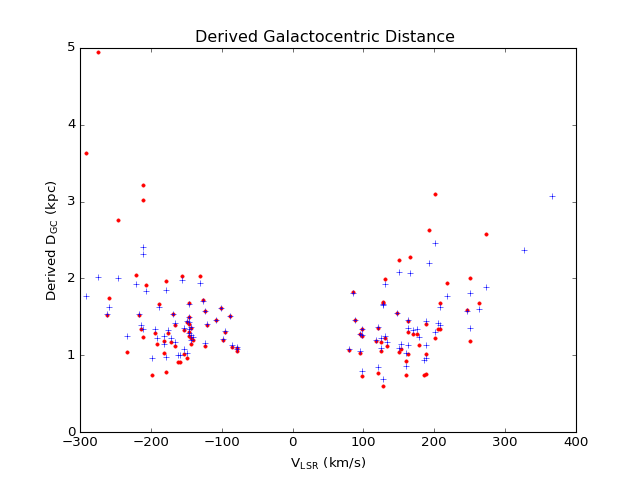

(0.0, 5.0)

In [10]:
# Work on the GBT data
Vw = 300.
derived_VLSR, derived_cloud_R,derived_cloud_dGC,derived_cloud_x, derived_cloud_y, derived_cloud_y, derived_cloud_z, derived_cloud_theta,derived_cloud_phi = derived_props(lon,lat,vel,Vw)

pylab.figure()
pylab.plot(vel,derived_cloud_dGC,'r.')
#pylab.ylim(0.,3.)
pylab.xlabel("$V_{LSR}$ (km/s)")
pylab.ylabel("Derived $D_{GC}$ (kpc)")
pylab.title("Derived Galactocentric Distance ")
derived_VLSR, derived_cloud_R,derived_cloud_dGC,derived_cloud_x, derived_cloud_y, derived_cloud_y, derived_cloud_z, derived_cloud_theta, derived_cloud_phi = derived_props_accel(lon,lat,vel)
pylab.plot(vel,derived_cloud_dGC,'b+')
pylab.ylim(0.,5.)

Caption: Red circles are with constant wind velocity, blue crosses have an acceleration.  There are some high-velocity red points that are off the scale shown.

<IPython.core.display.Javascript object>


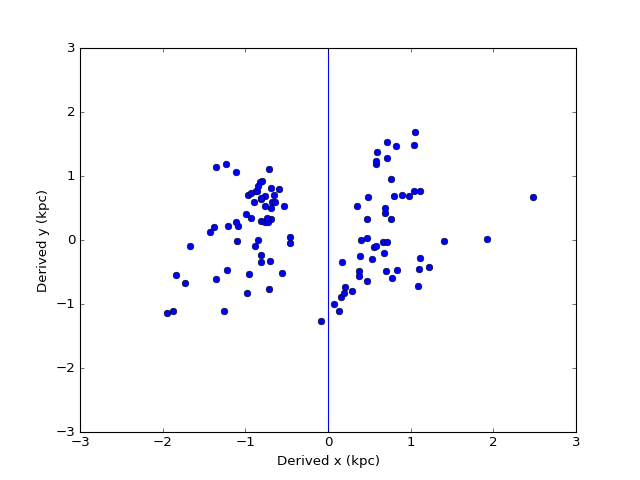

(-3.0, 3)

In [11]:
pylab.figure()
pylab.plot(derived_cloud_x,derived_cloud_y,'bo')
pylab.xlabel("Derived x (kpc)")
pylab.ylabel("Derived y (kpc)")
pylab.axvline(0.)
pylab.xlim(-3.,3)
pylab.ylim(-3.,3)

Note: In this definition of the coordinate system the Sun is at $x = -8.5$ kpc.

## Calculate the distribution of angles, $\phi$, for an assumed wind speed.

<IPython.core.display.Javascript object>


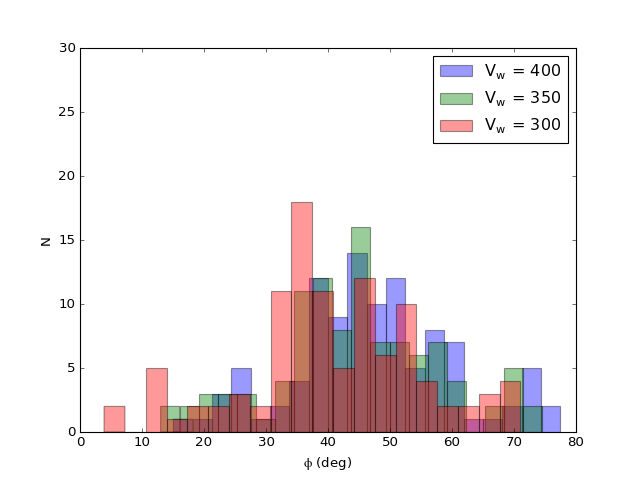

In [13]:
wind_vels = np.arange(400.,250.,-50.)
pylab.figure()
for Vw in wind_vels:
    #pylab.figure()
    derived_VLSR, derived_cloud_R,derived_cloud_dGC,derived_cloud_x, derived_cloud_y, derived_cloud_y, derived_cloud_z, derived_cloud_theta,derived_cloud_phi = derived_props(lon,lat,vel,Vw)
    vel_str = "$V_w$ = %.f" % Vw
    n,bins,patches = pylab.hist(abs(derived_cloud_phi),20,alpha=0.4,label=vel_str)
    pylab.xlabel("$\phi$ (deg)")
#pylab.title(vel_str)
pylab.legend()
pylab.ylim(0.,30.)
pylab.ylabel("N")

## Cloud Lifetimes

<IPython.core.display.Javascript object>


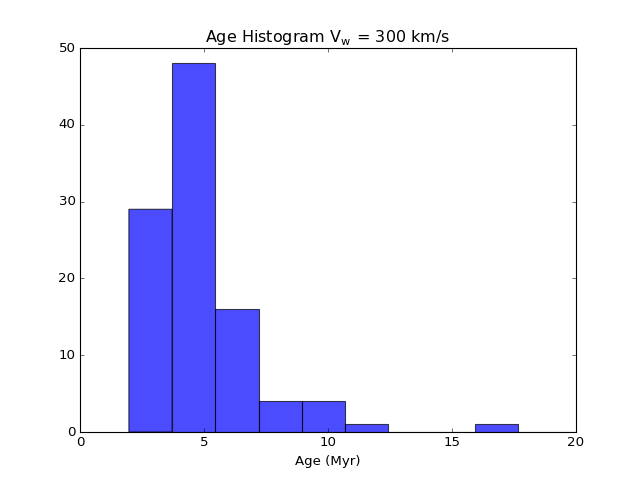

(0, 20.0)

In [16]:
Vw = 300.
derived_VLSR, derived_cloud_R,derived_cloud_dGC,derived_cloud_x, derived_cloud_y, derived_cloud_y, derived_cloud_z, derived_cloud_theta, derived_cloud_phi = derived_props(lon,lat,vel,Vw)
age = derived_cloud_dGC/ Vw * 977813106/1.e6
pylab.figure()
vel_str = "$V_w$ =%.f km/s" % Vw
n, bins, patches = pylab.hist(age,30,alpha=0.7)
pylab.xlabel("Age (Myr)")
pylab.savefig("age_hist.pdf")
title_str = "Age Histogram $V_w$ = %.f km/s" % Vw
pylab.title(title_str)
pylab.xlim(0,20.)

<IPython.core.display.Javascript object>


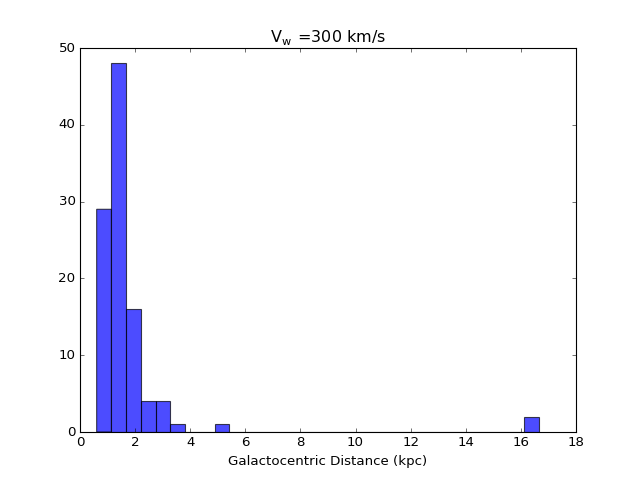

<IPython.core.display.Javascript object>


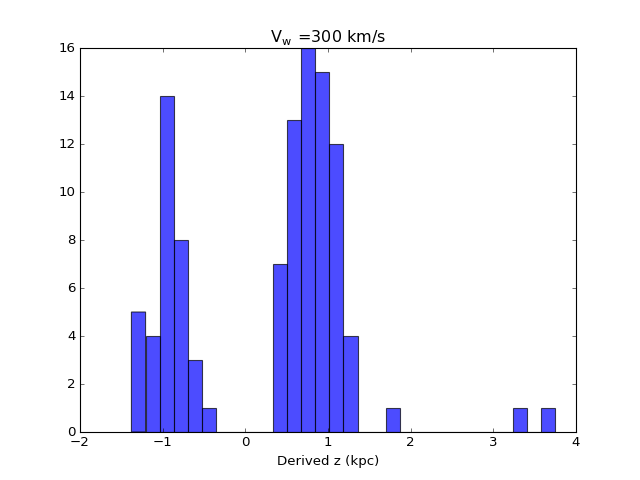

In [17]:
pylab.figure()
n, bins, patches = pylab.hist(derived_cloud_dGC,30,alpha=0.7)
pylab.xlabel("Galactocentric Distance (kpc)")
pylab.title(vel_str)
pylab.figure()
n,bins,patches = pylab.hist(derived_cloud_z,30,alpha=0.7)
pylab.xlabel("Derived z (kpc)")
pylab.title(vel_str)

<IPython.core.display.Javascript object>


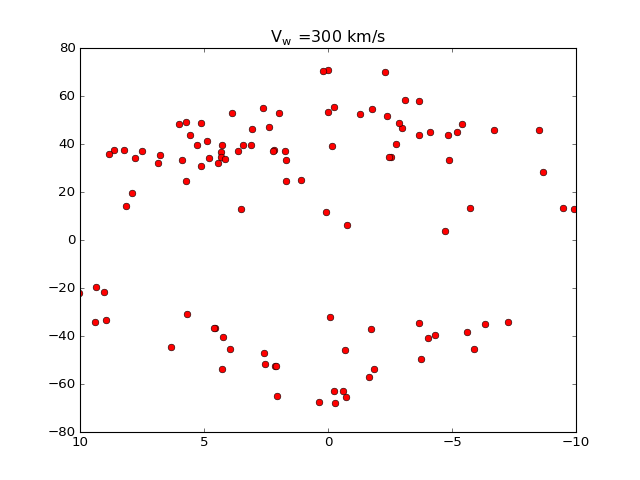

In [18]:
pylab.figure()
pylab.plot(lon,derived_cloud_phi,'ro')
pylab.xlim(10.,-10.)
pylab.title(vel_str)

## Now include the ATCA data 

In [19]:
all_lon = np.append(lat,atca_lat)
all_lat = np.append(lat,atca_lat)
all_vel = np.append(vel,atca_vel)

<IPython.core.display.Javascript object>


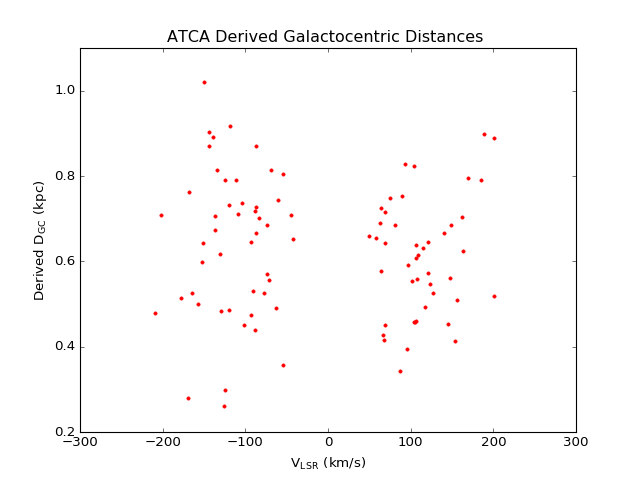

In [20]:
Vw = 350.
atca_VLSR, atca_cloud_R,atca_cloud_dGC,atca_cloud_x, atca_cloud_y, atca_cloud_y, atca_cloud_z, atca_cloud_theta,atca_cloud_phi = derived_props(atca_lon,atca_lat,atca_vel,Vw)
pylab.figure()
pylab.plot(atca_vel,atca_cloud_dGC,'r.')
#pylab.ylim(0.,3.)
pylab.xlabel("$V_{LSR}$ (km/s)")
pylab.ylabel("Derived $D_{GC}$ (kpc)")
pylab.title("ATCA Derived Galactocentric Distances ")



<IPython.core.display.Javascript object>


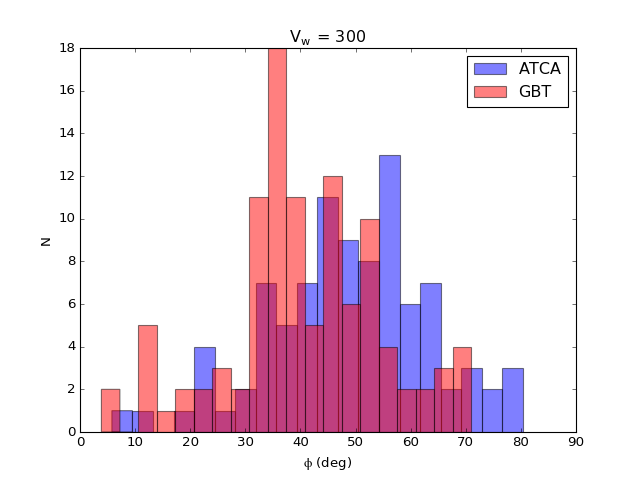

In [23]:
pylab.figure()
Vw = 300.
atca_VLSR, atca_cloud_R,atca_cloud_dGC,atcs_cloud_x, atca_cloud_y, atca_cloud_y, atca_cloud_z, atca_cloud_theta,atca_cloud_phi = derived_props(atca_lon,atca_lat,atca_vel,Vw)
n,bins,patches = pylab.hist(abs(atca_cloud_phi),20,alpha=0.5,color='blue',label="ATCA")
n,bins,patches = pylab.hist(abs(derived_cloud_phi),20,alpha=0.5,color='red',label="GBT")

#all_VLSR, all_cloud_R,all_cloud_dGC,all_cloud_x, all_cloud_y, all_cloud_y, all_cloud_z, all_cloud_theta,all_cloud_phi = derived_props(all_lon,all_lat,all_vel,Vw)
vel_str = "$V_w$ = %.f" % Vw
#n,bins,patches = pylab.hist(abs(all_cloud_phi),20,alpha=0.5,label=vel_str)
pylab.xlabel("$\phi$ (deg)")
pylab.title(vel_str)
pylab.legend()
#pylab.ylim(0.,30.)
pylab.ylabel("N")

<IPython.core.display.Javascript object>


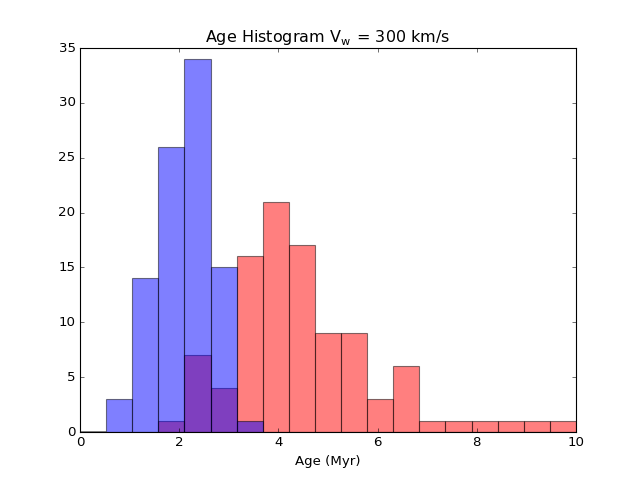

In [24]:
age = derived_cloud_dGC/ Vw * 977813106/1.e6
pylab.figure()
bin=np.linspace(0.0, 10., 20)
n, bins, patches = pylab.hist(age,bin,alpha=0.5,color='red',label="GBT")

atca_age =atca_cloud_dGC/ Vw * 977813106/1.e6
n, bins, patches = pylab.hist(atca_age,bin,alpha=0.5,color='blue',label="ATCA")
pylab.xlabel("Age (Myr)")
pylab.savefig("age_hist.pdf")
title_str = "Age Histogram $V_w$ = %.f km/s" % Vw
pylab.title(title_str)
#pylab.xlim(0,20.)

